# The Problem of Loanwords: Detection and Remedies

## What is a Loanword?
They are real: https://en.wikipedia.org/wiki/Loanword but they often overlooked in everyday use. Take this example conversation:
* "It was nice seeing you again. Adios amigo."
* Until we meet again, "Vaya con Dios!"

#### The last two sentences are loanwords, borrowings from Spanish. Most participants can navigate and interpret conversations even if they don't know the exact translations of the loanwords.

However, when doing Natural Language Processing loanwords may become a pesky problem, for example:
* If you are trying to generate a high quality embedding
    * you many need to detect and drop out the loanwords since they are out of scope for typical monolingual embeddings.
* If your application is translating a sequence of sentences
    * you may need to switch models to create a better translation of a loanword sequence.
* Some loanwords may occur in both languages 
    * you will need to use other heuristic measures to increase your precision and recall in detection.
#### etc.
### So let's look at how we can detect and work around these problem areas.

### In this notebook you will:
1. Perform ETL (Extract-Transform-Load)
    1. Extract data using a Corpus Reader object
    1. Transform the data using a reusable, composable Scikit-Learn Pipeline object
    1. Load the data into a matrix and train a classifier
1. Train several classifiers and select the best algorithm for the data
1. Use GridSearch to tune hyperparameters to achieve the best algorithm performance
1. Use the classifier to predict the classification of each word
1. Extract whole phrases by clustering occurences of predicted words 
1. Save the pipelines and classifier for reuse at runtime
1. Record the trained classifier model's provenance
1. Examine some unseen, untrained data to discover how well the classifier generalizes to unseen data

## Our problem: Detect Transliterated Greek in Classical Latin Authors
### Why? 
### To make a high quality word embedding, using a relatively limited corpus, it's important to filter out foreign words. Often Latin authors will quote Greek authors and transliterate the Greek into Latin equivalents; however the resulting words often haven't been generally adopted in the language. True, some transliterated Greek words are valid Latin words, but we aren't concerned about a word here or there, but rather clusters of foreign words in the source language. 
### We will generate our data sets using CLTK (Classical Language Toolkit http://cltk.org/ ):
* The Latin Library
    * Julius Caesar
    * Prudentius
    * Eutropius
* The Perseus Library Greek Texts
    * The Works of Plato
    * Homer's Odyssey
* We will augment our Latin data set using probability distributions in tandem with CLTK's lemmatization dictionary.

#### The probability distributions come from our other notebooks:
* `probablistic_language_modeling/make_frequency_distribution.ipynb` 
* `detecting_loanwords/make_frequency_distribution_greek_transliterated.ipynb`

#### The Greek will be transliterated into Latin. 
#### We will use our classifier to examine the corpus of Pliny the Younger to detect the use of transliterated Greek words, and we'll assess the classifier's effectiveness on the entire Latin Library corpus.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

### Imports

In [2]:
import datetime
import glob
import json
import logging
import multiprocessing
import os
import site
from copy import deepcopy
import random
from collections import defaultdict
import pickle

import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve, ShuffleSplit, train_test_split, GridSearchCV, cross_val_score
from scipy import sparse
from tqdm import tqdm
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils.extmath import density
from sklearn.dummy import DummyClassifier
from joblib import dump, load
import sklearn
from sklearn.preprocessing import FunctionTransformer, LabelEncoder, StandardScaler
from cltk.stem.latin.j_v import JVReplacer
from cltk.prosody.latin.scansion_constants import ScansionConstants
from cltk.prosody.latin.string_utils import remove_punctuation_dict
from cltk.tokenize.word import WordTokenizer
from cltk.corpus.readers import get_corpus_reader
from cltk.utils.featurization import word_to_features
from cltk.utils.file_operations import md5
from cltk.utils.matrix_corpus_fun import (
    distinct_words,
    separate_camel_cases,
    drop_empty_lists,
    drop_non_lower,
    drop_arabic_numeric,
    drop_all_caps,
    drop_empty_strings,
    jv_transform,
    splice_hyphens,
    accept_editorial,
    profile_chars,
    demacronize,
    drop_enclitics,
    drop_fringe_punctuation,
    divide_separate_words,
    drop_all_punctuation)
plt.style.use('fivethirtyeight')

### Add parent directory to path so we can access our common code

In [3]:
import os
import sys
import inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0, parentdir) 

In [4]:
from mlyoucanuse.romanizer import Romanizer, romanizer_transform  
from mlyoucanuse.aeoe_replacer import aeoe_transform
from mlyoucanuse.matrix_fun import (run_length_encoding,
                                    extract_words,                                     
                                    patch_cluster_holes)
from mlyoucanuse.featurize_text_fun import word_to_features

### Turn on logging, primarily so that library methods may report warnings, if any

In [5]:
LOG = logging.getLogger('make_model')
LOG.addHandler(logging.NullHandler())
logging.basicConfig(level=logging.INFO)

### Define a CorpusReader and select only the text files of Prudentius, Caesar and Eutropius. 
#### As shown in the appendix of this notebook, the authors of this seed set have a low incidence of using transliterated Greek words.

In [6]:
latin_reader = get_corpus_reader('latin_text_latin_library', language='latin')
ALL_FILE_IDS = list(latin_reader.fileids())
good_files = [file for file in ALL_FILE_IDS
              if 'prudentius' in file or
              'caesar' in file or
              'eutropius' in file]
LOG.info('available good files %s', len(good_files))
latin_reader._fileids = good_files
good_files

INFO:make_model:available good files 41


['caesar/alex.txt',
 'caesar/bc1.txt',
 'caesar/bc2.txt',
 'caesar/bc3.txt',
 'caesar/bellafr.txt',
 'caesar/gall1.txt',
 'caesar/gall2.txt',
 'caesar/gall3.txt',
 'caesar/gall4.txt',
 'caesar/gall5.txt',
 'caesar/gall6.txt',
 'caesar/gall7.txt',
 'caesar/gall8.txt',
 'caesar/hisp.txt',
 'eutropius/eutropius1.txt',
 'eutropius/eutropius10.txt',
 'eutropius/eutropius2.txt',
 'eutropius/eutropius3.txt',
 'eutropius/eutropius4.txt',
 'eutropius/eutropius5.txt',
 'eutropius/eutropius6.txt',
 'eutropius/eutropius7.txt',
 'eutropius/eutropius8.txt',
 'eutropius/eutropius9.txt',
 'prudentius/prud.psycho.txt',
 'prudentius/prud1.txt',
 'prudentius/prud10.txt',
 'prudentius/prud11.txt',
 'prudentius/prud12.txt',
 'prudentius/prud13.txt',
 'prudentius/prud14.txt',
 'prudentius/prud2.txt',
 'prudentius/prud3.txt',
 'prudentius/prud4.txt',
 'prudentius/prud5.txt',
 'prudentius/prud6.txt',
 'prudentius/prud7.txt',
 'prudentius/prud8.txt',
 'prudentius/prud9.txt',
 'suetonius/suet.caesar.txt',
 'xyl

In [7]:
# remove some unfamiliar entries
questionable = ['caesar/alex.txt',
                'caesar/hisp.txt',
                'prudentius/prud.psycho.txt',
                'suetonius/suet.caesar.txt',
                'xylander/caesar.txt']
for file in questionable:
    good_files.remove(file)


### Define a custom Scikit-learn Pipeline, and call the CorpusReader `words()` method to process the texts
#### The functions used in the pipelines are doctest documented in the `corpus_cleaning` module
#### The functions used and their order was developed iteratively by running the pipelines on actual data and carefully inspecting the results prior to runnning it through featurization. Always know your data!

#### Lastly, we use the joblib library to save/pickle the pipeline so that it can be reloaded and reused.

In [8]:
process_latin_text_pipeline = Pipeline([
    ('separate_camel_cases', FunctionTransformer(separate_camel_cases, validate=False)),
    ('splice_hyphens', FunctionTransformer(splice_hyphens, validate=False)),
    ('jv_transform', FunctionTransformer(jv_transform, validate=False)),
    ('aeoe_transform', FunctionTransformer(aeoe_transform, validate=False)),
    ('accept_editorial', FunctionTransformer(accept_editorial, validate=False)),
    ('drop_enclitics', FunctionTransformer(drop_enclitics, validate=False)),
    ('drop_fringe_punctuation', FunctionTransformer(drop_fringe_punctuation, validate=False)),
    ('drop_all_punctuation', FunctionTransformer(drop_all_punctuation, validate=False)),
    ('drop_non_lower', FunctionTransformer(drop_non_lower, validate=False)),
    ('drop_arabic_numeric', FunctionTransformer(drop_arabic_numeric, validate=False)),
    ('drop_all_caps', FunctionTransformer(drop_all_caps, validate=False)),
    ('divide_separate_words', FunctionTransformer(divide_separate_words, validate=False)),
    ('drop_empty_lists', FunctionTransformer(drop_empty_lists, validate=False)),
    ('drop_empty_strings', FunctionTransformer(drop_empty_strings, validate=False))])

process_latin_text_pipeline_file = 'process_latin_text_pipeline.{}.joblib'.format(
    sklearn.__version__)
dump(process_latin_text_pipeline, process_latin_text_pipeline_file)


['process_latin_text_pipeline.0.22.1.joblib']

In [9]:
X = process_latin_text_pipeline.fit_transform(tqdm([list(latin_reader.words())]))

100%|██████████| 1/1 [00:00<00:00, 27.98it/s]


* Analyze the resulting matrix, by profiling the character occurences
* Go back and adjust the pipeline as necessary
* Turn the output into a distinct set of words

In [10]:
char_count = profile_chars(X)
print('Character distribution profile, total chars:', sum(char_count.values()))
print(char_count)
distinct_good_latin = distinct_words(X)
print(f'Number of distinct words in Eutropius/Prudentius/Caesar sample: {len(distinct_good_latin):,}')
print(f'Number of distinct characters: {len(char_count)}')

Character distribution profile, total chars: 810409
Counter({'e': 93828, 'i': 90246, 'u': 75553, 't': 67540, 'a': 65821, 's': 62825, 'r': 54357, 'n': 49472, 'o': 44779, 'm': 41221, 'c': 31563, 'p': 23317, 'l': 23269, 'd': 20970, 'b': 13064, 'q': 12561, 'g': 8357, 'f': 7372, 'x': 4467, 'h': 4172, 'C': 2515, 'A': 1473, 'I': 1185, 'P': 1119, 'H': 1079, 'S': 1078, 'R': 965, 'G': 770, 'Q': 607, 'M': 601, 'T': 557, 'U': 546, 'N': 529, 'L': 475, 'E': 469, 'D': 459, 'y': 399, 'B': 351, 'F': 211, 'O': 203, 'z': 23, 'Z': 16, 'K': 11, 'k': 10, 'X': 3, 'Å': 1})
Number of distinct words in Eutropius/Prudentius/Caesar sample: 25,773
Number of distinct characters: 46


### After running this notebook several times, we've decided to load in more training data, which is provide by the notebook:
* `boosting_training_data.ipynb`

In [11]:
additional_latin_words = []
with open('latin.lemma.forms.txt', 'rt') as reader:
    additional_latin_words = reader.read().split('\n')
random.sample(additional_latin_words, 5)

['recusabunt', 'duritiis', 'adfluentibus', 'Pyramus', 'linteolis']

In [12]:
print(f'additional_latin_words: {len(additional_latin_words):,}')
distinct_good_latin= list(set(distinct_good_latin) | set(additional_latin_words))
print(f'distinct_good_latin now: {len(distinct_good_latin):,}')

additional_latin_words: 175,970
distinct_good_latin now: 179,919


* Load the Greek texts of Homer and Plato (two of the most commonly quoted Greek authors)
* Preprocess the text
* Transliterate into Classical Latin

#### We save this pipeline for reuse too.

In [9]:
perseus_greek = get_corpus_reader(language='greek', corpus_name='greek_text_perseus')
plato = [tmp for tmp in perseus_greek.fileids() if 'plato' in tmp]
homer = [tmp for tmp in perseus_greek.fileids() if 'homer' in tmp]
greek_texts = plato + homer

process_greek_pipeline = Pipeline([
    ('accept_editorial', FunctionTransformer(accept_editorial, validate=False)),  # problematic
    ('romanizer', FunctionTransformer(romanizer_transform, validate=False)),
    ('drop_fringe_punctuation', FunctionTransformer(drop_fringe_punctuation, validate=False)),
    ('drop_all_punctuation', FunctionTransformer(drop_all_punctuation, validate=False)),
    ('drop_arabic_numeric', FunctionTransformer(drop_arabic_numeric, validate=False)),  #ok
    ('drop_empty_lists', FunctionTransformer(drop_empty_lists, validate=False)),  # problem?
    ('drop_empty_strings', FunctionTransformer(drop_empty_strings, validate=False))  # problem?
])

process_greek_text_pipeline_file = 'process_greek_text_pipeline.{}.joblib'.format(
    sklearn.__version__)
dump(process_greek_pipeline, process_greek_text_pipeline_file)

['process_greek_text_pipeline.0.22.1.joblib']

In [14]:
X_greek_transliterated = process_greek_pipeline.fit_transform(tqdm([list(perseus_greek.words(greek_texts))]))

100%|██████████| 1/1 [00:00<00:00,  9.64it/s]


* Analyze the transliterated Greek examples
* Check character profiles for tuning
* Create a set distinct words, with and without macrons

In [15]:
greek_char_count = profile_chars(X_greek_transliterated)
print('Character distribution profile of transliterated Greek: ', greek_char_count )
distinct_transliterated_greek_examples = distinct_words(X_greek_transliterated)
print(f'{len(distinct_transliterated_greek_examples):,} distinct_transliterated_greek_examples')
distinct_demacronized_greek = distinct_words(demacronize(X_greek_transliterated))
print(f'{len(distinct_demacronized_greek):,} distinct_demacronized_greek')

Character distribution profile of transliterated Greek:  Counter({'a': 176222, 'e': 172410, 'o': 159911, 'i': 158418, 'n': 143139, 't': 142875, 's': 107062, 'h': 91529, 'u': 74411, 'p': 66229, 'k': 63931, 'ē': 63161, 'r': 56352, 'm': 52545, 'l': 49342, 'ō': 48812, 'd': 42019, 'g': 29246, 'b': 6357, 'x': 4571, 'S': 4393, 'E': 3738, 'Ō': 3736, 'A': 3441, 'z': 2850, 'T': 2102, 'P': 1859, 'I': 1327, 'R': 1056, 'X': 1044, 'K': 1004, 'L': 979, 'O': 859, 'D': 743, 'N': 667, 'M': 651, 'H': 461, 'Z': 234, 'Ē': 164, 'Y': 143, 'G': 53, 'B': 35, 'y': 23, 'F': 11, 'f': 5, 'c': 5, ' ': 4, 'V': 2, 'C': 2, 'v': 2, 'U': 1})
41,552 distinct_transliterated_greek_examples
39,982 distinct_demacronized_greek


In [16]:
char_idx = {' ':0}
curr_idx=1

all_chars = sorted(list(char_count.keys()) + list(greek_char_count.keys()))

for car in all_chars:
    if car not in char_idx:
        char_idx[car] =curr_idx
        curr_idx+=1
        

total_uniq_char_count = len(char_idx )
print('total_uniq_char_count', total_uniq_char_count)


def encode_word(word, char_idx, max_len=28):
    vals =np.zeros(max_len)
    for idx, car in enumerate(word):
        vals[idx] = char_idx.get(car, 0) / len(char_idx) # total_uniq_char_count
    return vals
    

total_uniq_char_count 54


In [17]:
len(char_idx)

54

In [18]:
print( char_idx)

{' ': 0, 'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7, 'H': 8, 'I': 9, 'K': 10, 'L': 11, 'M': 12, 'N': 13, 'O': 14, 'P': 15, 'Q': 16, 'R': 17, 'S': 18, 'T': 19, 'U': 20, 'V': 21, 'X': 22, 'Y': 23, 'Z': 24, 'a': 25, 'b': 26, 'c': 27, 'd': 28, 'e': 29, 'f': 30, 'g': 31, 'h': 32, 'i': 33, 'k': 34, 'l': 35, 'm': 36, 'n': 37, 'o': 38, 'p': 39, 'q': 40, 'r': 41, 's': 42, 't': 43, 'u': 44, 'v': 45, 'x': 46, 'y': 47, 'z': 48, 'Å': 49, 'Ē': 50, 'ē': 51, 'Ō': 52, 'ō': 53}


In [19]:
the_char_idx = {' ': 0, 'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7, 'H': 8, 'I': 9, 'K': 10, 'L': 11, 'M': 12, 'N': 13, 'O': 14, 'P': 15, 'Q': 16, 'R': 17, 'S': 18, 'T': 19, 'U': 20, 'V': 21, 'X': 22, 'Y': 23, 'Z': 24, 'a': 25, 'b': 26, 'c': 27, 'd': 28, 'e': 29, 'f': 30, 'g': 31, 'h': 32, 'i': 33, 'k': 34, 'l': 35, 'm': 36, 'n': 37, 'o': 38, 'p': 39, 'q': 40, 'r': 41, 's': 42, 't': 43, 'u': 44, 'v': 45, 'x': 46, 'y': 47, 'z': 48, 'Å': 49, 'Ē': 50, 'ē': 51, 'Ō': 52, 'ō': 53}

### See how many words from the transliterated Greek words which have also appear in the Latin corpus

In [20]:
shared_words = distinct_demacronized_greek & set(distinct_good_latin)
print(f'Shared_words: {len(shared_words)} : {shared_words}')

Shared_words: 524 : {'anathema', 'demo', 'Rhodope', 'damna', 'Antiphates', 'Euenos', 'dogma', 'toros', 'patres', 'Atrei', 'e', 'pedo', 'philo', 'phono', 'nome', 'Dardanide', 'parentes', 'in', 'dote', 'neo', 'xanthe', 'metis', 'agre', 'eges', 'muri', 'sito', 'peribolo', 'oro', 'Diomedeos', 'nassa', 'di', 'r', 'eri', 'notio', 'pales', 'hamos', 'mel', 'throno', 'pleto', 'Herme', 'agrio', 'ara', 'esto', 'Eos', 'ore', 'Argos', 'philosopho', 'audes', 'emat', 'Atreus', 'spei', 'pio', 'med', 'doma', 'melle', 'esset', 'ose', 'Amphitrites', 'asto', 'sus', 'det', 'geode', 'exite', 'eris', 'plana', 'aloes', 'Parmenide', 'tris', 'ergo', 'trite', 'tauros', 'manenti', 'paries', 'Thesea', 'ale', 'Delo', 'lego', 'nota', 'sto', 'poma', 'dogmata', 'aloe', 'erga', 'daphne', 'elusa', 'os', 'osi', 'eras', 'Lampetie', 'ites', 'Orion', 'io', 'Lapithas', 'bolos', 'mela', 'ae', 'polles', 'times', 'erato', 'lino', 'heroi', 'agro', 'hei', 'noma', 'Thebe', 'mori', 'Apollo', 'hesperos', 'philosophos', 'problemata',

#### These shared words appear in both language corpora; however, intuitively, we know each word will have a different probability of occurrence in each language. So, rather than arbitrarily excluding some or all of the words from one language or the other, we should split them into the most common probable groups. We can do this by loading the probability distribution pickle objects we have created in the notebooks:
* `building_language_model/make_frequency_distribution.ipynb` 
* `detecting_loanwords/make_frequency_distribution_greek_transliterated.ipynb`

### Load Frequency Distributions for Latin and transliterated Greek

In [21]:
greek_transliterated_word_probs = {}
with open('freq_dist.greek.transliterated.pkl', 'rb') as reader:
    greek_transliterated_word_probs = pickle.load(reader)
    
latin_word_probs = {}
with open(os.path.join('../probablistic_language_modeling', 'freq_dist.latin.pkl'), 'rb') as reader:
    latin_word_probs = pickle.load(reader)

#### We'll create a list of tuples containing (the word, the words probability in Latin, the words probability in Greek)

In [22]:
shared_latin_greek = [(word, 
                       latin_word_probs.get(word, 1e-06),
                       greek_transliterated_word_probs.get(word, 1e-06)) 
                      for word in shared_words]

shared_latin_greek.sort(key=lambda a: a[1], reverse=True)
for item in shared_latin_greek:
    print(item)

('et', 0.9999900000000002, 0.001594731640385874)
('in', 0.6195366094371269, 0.002322993118442995)
('est', 0.40047688283934835, 0.0015525135836869104)
('non', 0.3655202190736462, 1.0000000000000006e-06)
('de', 0.16358695886651264, 0.5190825616279315)
('a', 0.13448064535122392, 0.002914045912228485)
('ex', 0.13319985495959372, 0.02580678715724147)
('per', 0.11551978686121114, 0.0049721761763029575)
('esse', 0.11489112051513624, 1e-06)
('se', 0.10337573584020457, 0.019231324826377898)
('aut', 0.09289014417246275, 0.0011619965592214974)
('me', 0.06858796751076134, 0.016392160513372597)
('te', 0.068280671647568, 0.1623927550925633)
('id', 0.059277606586987885, 0.00039151702446541285)
('ne', 0.05901722612275537, 2.2109028349481774e-05)
('eo', 0.05369232834070303, 1.1554514174740887e-05)
('pro', 0.051006421750196464, 0.00823352105629789)
('ea', 0.04345773405740157, 0.0006131618221349714)
('erat', 0.03941362666697944, 1e-06)
('ei', 0.034644676362612745, 0.07388259922318621)
('esset', 0.0346352

`kai` is the most common word in the Greek corpus, so we could also divide the shared words by the threshold of this probability

In [23]:
latin_word_probs.get('kai')

0.0011142407253193212

In [24]:
likely_latin = [word for word, latin_prob, greek_prob 
                in shared_latin_greek 
                if latin_prob >= latin_word_probs['kai']]
print(len(likely_latin))
random.sample(likely_latin, 9)

97


['suos', 'at', 'pares', 'has', 'eris', 'esse', 'de', 'deos', 'ea']

In [25]:
greater_prob_latin = [word for word, latin_prob, greek_prob
                     in shared_latin_greek
                     if latin_prob >= greek_prob]
print(len(greater_prob_latin))
random.sample(greater_prob_latin, 9)

487


['arere',
 'Euripo',
 'pio',
 'Europes',
 'dote',
 'agro',
 'Hesiodo',
 'Stesichorus',
 'agre']

In [26]:
# We'll remove the words that have a high probability of being Latin 
# from the collection of demacronized transliterated Greek words
only_greek_transliterated = distinct_demacronized_greek - set(likely_latin)
likely_greek = shared_words - set(likely_latin)

# Likewise, let's remove the transliterated words that are likely Greek 
# from the collection of good Latin words
distinct_good_latin = set(distinct_good_latin) - likely_greek

print(f'{len(only_greek_transliterated):,} distinct transliterated Greek words without matches in the Latin corpus')

# NOTE: we are toggling this on to see the difference
# only_greek_transliterated=  distinct_demacronized_greek
# distinct_latin_wo_greek_matches = distinct_good_latin - shared_words
# The following had low precision high recall:
# only_greek_transliterated = distinct_demacronized_greek - shared_words

39,885 distinct transliterated Greek words without matches in the Latin corpus


### Normally these gaps might concern us, but since we are more interested in groups of loanwords in phrases, we can rely on smoothing over clusters of loanwords to screen out misses.

### Create a simple data matrix of the single words, transliterated Greek examples followed by the Latin words

In [27]:
X = [list(only_greek_transliterated) + list(distinct_good_latin)]
len(X[0])

219377

### Before we featurize our data matrix, let's check on the max word lengths

In [28]:
max_latin_len=sorted([len(tmp) for tmp in distinct_good_latin])[-1]
max_greek_len =sorted([len(tmp) for tmp in only_greek_transliterated])[-1] 
max_len =max(max_latin_len, max_greek_len)
print(f'{max_latin_len} Max word length in distinct good Latin sample')
print(f'{max_greek_len} Max word length in transliterated Greek sample')

28 Max word length in distinct good Latin sample
24 Max word length in transliterated Greek sample


In [29]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(all_X, all_y, test_size=0.30)
x_test, x_validation, y_test, v =train_test_split(x_test, y_test, test_size=0.5)

In [ ]:
scaler = StandardScaler()
# try:  all_X.astype(np.float64)
# Fit scaler only on training slice of data; 
# As with all the transformations, it is important to fit the scalers to the training data only,
# not to the full dataset (including the test set).
scaler.fit(X_train.astype(np.float32))
# TODO pickle this scaler for applying the same transforms to input
with open('scaler.pkl', 'wb') as fwriter:
    pickle.dump(scaler, fwriter)    
# Fit all 3 data sets
X_train = scaler.transform(X_train.astype(np.float32))
X_test = scaler.transform(X_test.astype(np.float32))
X_validation = scaler.transform(X_validation.astype(np.float32))

## Featurization
#### We'll use a generic character to integer transform so that we can reuse our encoding process for unseen character data combinations (as opposed to building a dictionary mapping for a discrete sample space)

#### Let's create the X,y feature matrix and labels and save them for re-use in other notebooks

In [29]:
all_y = np.array([1] * len(only_greek_transliterated) + [0] * len(distinct_good_latin), dtype=int)
print(f'y shape: {all_y.shape}')
with open('all_y', 'wb') as fwriter:
    pickle.dump(all_y, fwriter)
# We use a label encoder to automatically capture the range of values for provenance
# Although it's true we're only doing binary classification, 
# it's a good practice to use this so that we can automate recording our model's provenance
label_encoder = LabelEncoder()
label_encoder.fit(all_y)
all_words = list(only_greek_transliterated) + list(distinct_good_latin)
all_X = np.array([
#     word_to_features(word, max_len) 
    encode_word(word, the_char_idx, max_len)
    for word in all_words])
print(f'X shape: {all_X.shape}')

y shape: (219377,)
X shape: (219377, 28)


In [30]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(all_X, all_y, test_size=0.30)
X_test, X_validation, y_test, y_validation =train_test_split(X_test, y_test, test_size=0.5)

In [31]:
# standard scalar
scaler = StandardScaler()
# try:  all_X.astype(np.float64)
# Fit scaler only on training slice of data; 
# As with all the transformations, it is important to fit the scalers to the training data only,
# not to the full dataset (including the test set).
scaler.fit(all_X.astype(np.float32))
# TODO pickle this scaler for applying the same transforms to input
with open('scaler.pkl', 'wb') as fwriter:
    pickle.dump(scaler, fwriter)    
# Fit all 3 data sets
X_train = scaler.transform(X_train.astype(np.float32))
X_test = scaler.transform(X_test.astype(np.float32))
X_validation = scaler.transform(X_validation.astype(np.float32))

In [32]:
with open('all_X.pkl', 'wb') as fwriter:
    pickle.dump(all_X, fwriter)
all_X = sparse.csr_matrix(all_X)
with open('all_X_scaled.pkl', 'wb') as fwriter:
    pickle.dump(all_X, fwriter)
num_samples = all_y.shape[0] # to be used later by model provenance
num_features = all_X.shape[1] # to be used later by model provenance

### Train a DummyClassifier to show the baseline which we must improve above

In [33]:
dummy = DummyClassifier(strategy='stratified', random_state=0)
features_train, features_test, target_train, target_test = train_test_split(all_X, all_y,
                                                                            random_state=0)
dummy.fit(features_train, target_train)
dummy_score = dummy.score(features_test, target_test)
print(f'Dummy classifier: {dummy_score}')

Dummy classifier: 0.7043303856322363


### Train and classify the data using several classifiers, printing out the cross validation score results

In [77]:
classifiers = [
    KNeighborsClassifier,
    BaggingClassifier,
    ExtraTreesClassifier,
    RandomForestClassifier
]
for cls in tqdm(classifiers):
    scores = cross_val_score(cls(), all_X, all_y,
                             scoring='accuracy',
                             n_jobs=multiprocessing.cpu_count(),
                             cv=5)
    print(f"Classifier type: {str(cls)} mean score: {scores.mean()} scores: {','.join([str(tmp) for tmp in scores])}")


 25%|██▌       | 1/4 [08:16<24:49, 496.40s/it]

Classifier type: <class 'sklearn.neighbors.classification.KNeighborsClassifier'> mean score: 0.8701504715049067 scores: 0.8694958519463943,0.8708177591393929,0.8702222222222222,0.8711111111111111,0.8691054131054131



 50%|█████     | 2/4 [08:58<12:00, 360.02s/it]

Classifier type: <class 'sklearn.ensemble.bagging.BaggingClassifier'> mean score: 0.9579035273455183 scores: 0.9577673443340323,0.9559212325644999,0.9596125356125356,0.9567635327635328,0.9594529914529915



 75%|███████▌  | 3/4 [09:23<04:19, 259.51s/it]

Classifier type: <class 'sklearn.ensemble.forest.ExtraTreesClassifier'> mean score: 0.9417486903651551 scores: 0.940035554745191,0.941015589388276,0.9431111111111111,0.9397606837606838,0.9448205128205128



100%|██████████| 4/4 [09:41<00:00, 145.32s/it]

Classifier type: <class 'sklearn.ensemble.forest.RandomForestClassifier'> mean score: 0.95025003767416 scores: 0.9480353724131644,0.9499498586926793,0.9502678062678063,0.9495612535612535,0.9534358974358974


In [35]:
rf = RandomForestClassifier(n_estimators=300,
    bootstrap=True, class_weight=None, criterion='gini',
 max_depth=None, max_features='auto', max_leaf_nodes=None,
 min_impurity_decrease=1e-07, min_samples_leaf=1,
 min_samples_split=2, min_weight_fraction_leaf=0.0,
 n_jobs=-1, oob_score=True, random_state=None,
 verbose=0, warm_start=False)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print(f"oob score: {rf.oob_score_:.4f} x_test score {rf.score(X_test, y_test):.4f} validation score {rf.score(X_validation, y_validation):.4f}")
# 100
# 300 estimators
# oob: 0.9547221661467932, x_test 0.9544777706870878 0.9559972042422585 roc_auc 0.8880479620121011

oob score: 0.9626 x_test score 0.9625 validation score 0.9612


In [36]:
from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.9083355407702502

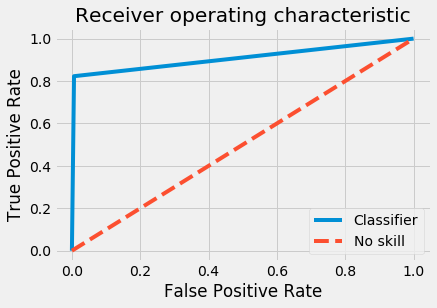

In [37]:
plt.figure()
plt.plot(false_positive_rate, true_positive_rate, label='Classifier')
plt.plot([0,1], ls='--', label='No skill')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [38]:
score= cross_val_score( RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
 max_depth=None, max_features='auto', max_leaf_nodes=None,
 min_impurity_decrease=1e-07, min_samples_leaf=1,
 min_samples_split=2, min_weight_fraction_leaf=0.0,
 n_estimators=300, n_jobs=-1, oob_score=False, random_state=None,
 verbose=0, warm_start=False) , all_X, all_y,
                             scoring='accuracy',
                             n_jobs=multiprocessing.cpu_count(),
                             cv=5)
score

array([0.96346522, 0.96385268, 0.96540171, 0.965151  , 0.96658689])

# If you want you can train and graph the effects of different parameters

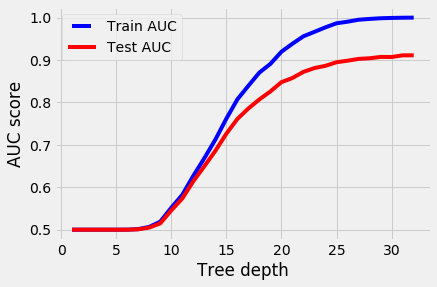

In [40]:
max_depths = np.linspace(1, 32, 32)
train_results = []
test_results = []
for max_depth in max_depths:
   rf = RandomForestClassifier(max_depth=max_depth, n_estimators=300,  n_jobs=-1)
   rf.fit(X_train, y_train)
   train_pred = rf.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = rf.predict(X_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_depths, train_results, 'b', label="Train AUC")
line2, = plt.plot(max_depths, test_results, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('Tree depth')
plt.show()

## Increasing the number of estimators increases the model size greatly, but soon additional estimators add very little predictive power

In [41]:
rf = RandomForestClassifier(n_estimators=300, n_jobs=-1, random_state=12)
rf.fit(X_train, y_train)
print(rf.score(X_test, y_test))
dump(rf, '/tmp/tmp.300.estimator.tree.pkl')
! ls -lh /tmp/tmp*

0.9644452548090072
-rw-r--r-- 1 todd todd 626M Mar 29 22:55 /tmp/tmp.300.estimator.tree.pkl


In [42]:
rf = RandomForestClassifier(n_estimators=800, n_jobs=-1, random_state=12)
rf.fit(X_train, y_train)
print(rf.score(X_test, y_test))
dump(rf, '/tmp/tmp.800.estimator.tree.pkl')
! ls -lh /tmp/tmp*

0.9646275868356277
-rw-r--r-- 1 todd todd 626M Mar 29 22:55 /tmp/tmp.300.estimator.tree.pkl
-rw-r--r-- 1 todd todd 1.7G Mar 29 22:55 /tmp/tmp.800.estimator.tree.pkl


### Run Grid Search to optimize one of the best classifiers
often one runs GridSearch to determine the parameters of the best classifier. However, it is fast a reliable to narrow the parameter window one at a time. Again, the general guidelines:
* scoring 100% on the training set indicates overfitting, and a decreased ability to generalize
* the difference between the test and validation sets indicate how well the data has been split

In [65]:
rf = RandomForestClassifier(n_estimators=300, n_jobs=-1, random_state=12)
rf.fit(X_train, y_train)
print(f"Training score: {rf.score(X_train, y_train)}")
print(f"Test score: {rf.score(X_test, y_test)}")
print(f"Validation score: {rf.score(X_validation, y_validation)}")

Training score: 1.0
Test score: 0.9644452548090072
Validation score: 0.9616494970674933


In [66]:
rf = RandomForestClassifier(n_estimators=300, max_depth=25, n_jobs=-1, random_state=12)
rf.fit(X_train, y_train)
print(f"Training score: {rf.score(X_train, y_train)}")
print(f"Test score: {rf.score(X_test, y_test)}")
print(f"Validation score: {rf.score(X_validation, y_validation)}")

Training score: 0.9947773877822131
Test score: 0.9580940225483939
Validation score: 0.9575470264685325


In [67]:
rf = RandomForestClassifier(n_estimators=300, max_features=0.4, n_jobs=-1, random_state=12)
rf.fit(X_train, y_train)
print(f"Training score: {rf.score(X_train, y_train)}")
print(f"Test score: {rf.score(X_test, y_test)}")
print(f"Validation score: {rf.score(X_validation, y_validation)}")

Training score: 1.0
Test score: 0.970249490989759
Validation score: 0.9678487859725894


In [68]:
rf = RandomForestClassifier(n_estimators=300, max_features='auto', n_jobs=-1, random_state=12)
rf.fit(X_train, y_train)
print(f"Training score: {rf.score(X_train, y_train)}")
print(f"Test score: {rf.score(X_test, y_test)}")
print(f"Validation score: {rf.score(X_validation, y_validation)}")

Training score: 1.0
Test score: 0.9644452548090072
Validation score: 0.9616494970674933


In [69]:
rf = RandomForestClassifier(n_estimators=300, max_features='sqrt', n_jobs=-1, random_state=12)
rf.fit(X_train, y_train)
print(f"Training score: {rf.score(X_train, y_train)}")
print(f"Test score: {rf.score(X_test, y_test)}")
print(f"Validation score: {rf.score(X_validation, y_validation)}")

Training score: 1.0
Test score: 0.9644452548090072
Validation score: 0.9616494970674933


In [70]:
rf = RandomForestClassifier(n_estimators=300, min_samples_leaf=2, n_jobs=-1, random_state=12)
rf.fit(X_train, y_train)
print(f"Training score: {rf.score(X_train, y_train)}")
print(f"Test score: {rf.score(X_test, y_test)}")
print(f"Validation score: {rf.score(X_validation, y_validation)}")

Training score: 0.989789207035549
Test score: 0.9552070987935698
Validation score: 0.9540827179627435


In [71]:
rf = RandomForestClassifier(n_estimators=300, min_samples_leaf=4, n_jobs=-1, random_state=12)
rf.fit(X_train, y_train)
print(f"Training score: {rf.score(X_train, y_train)}")
print(f"Test score: {rf.score(X_test, y_test)}")
print(f"Validation score: {rf.score(X_validation, y_validation)}")

Training score: 0.9689443420615643
Test score: 0.9436897924453763
Validation score: 0.942261524903516


In [72]:
rf = RandomForestClassifier(n_estimators=300, min_samples_split=5, n_jobs=-1, random_state=12)
rf.fit(X_train, y_train)
print(f"Training score: {rf.score(X_train, y_train)}")
print(f"Test score: {rf.score(X_test, y_test)}")
print(f"Validation score: {rf.score(X_validation, y_validation)}")

Training score: 0.9959104732259724
Test score: 0.9614367763697693
Validation score: 0.960160452183426


In [73]:
rf = RandomForestClassifier(n_estimators=300, min_samples_split=10, n_jobs=-1, random_state=12)
rf.fit(X_train, y_train)
print(f"Training score: {rf.score(X_train, y_train)}")
print(f"Test score: {rf.score(X_test, y_test)}")
print(f"Validation score: {rf.score(X_validation, y_validation)}")

Training score: 0.9861945911450024
Test score: 0.9560275929133619
Validation score: 0.9552070987935698


In [74]:
rf = RandomForestClassifier(n_estimators=300,
                            min_samples_split=4, min_samples_leaf=2,
                            n_jobs=-1, random_state=12)
rf.fit(X_train, y_train)
print(f"Training score: {rf.score(X_train, y_train)}")
print(f"Test score: {rf.score(X_test, y_test)}")
print(f"Validation score: {rf.score(X_validation, y_validation)}")

Training score: 0.989789207035549
Test score: 0.9552070987935698
Validation score: 0.9540827179627435


In [75]:
rf = RandomForestClassifier(n_estimators=300,
                            min_samples_split=4, min_samples_leaf=2,
                            max_features=0.4,
                            n_jobs=-1, random_state=12)
rf.fit(X_train, y_train)
print(f"Training score: {rf.score(X_train, y_train)}")
print(f"Test score: {rf.score(X_test, y_test)}")
print(f"Validation score: {rf.score(X_validation, y_validation)}")

Training score: 0.9943801566783665
Test score: 0.9667244051417632
Validation score: 0.9646883641778345


## Comments on the model parameters
* `min_samples_split` (default = 2) The minimum number of samples required to split an internal node
    * increasing this number has the effect of nudging the model towards generalization; it takes several examples to fork a branch in the decision tree
* `min_samples_leaf` (default=1) The minimum number of samples required to be at a leaf node.
    * "This may have the effect of smoothing the model, especially in regression." Increasing this number may encourage generalization, as a single example may not trigger a decision point/tree branch.

### We will still use grid search because:
* it will give us easy cross validation of our scores
* it will provide us with an easy way to extract our parameters

In [56]:
grids = GridSearchCV(cv=5, error_score='raise',
                     estimator=RandomForestClassifier()
                     , n_jobs=-1,
                     param_grid={
                        'n_estimators' : [300],                   
                        #  'max_depth': [25],
                        'max_features': [0.4], # 'auto', 'sqrt', 0.4],
                        'min_samples_leaf': [2] ,#1, 2, 4],
                        'min_samples_split': [4], #2, 5, 10]
                        })
grids.fit(all_X, all_y)
print('Best score: %s', grids.best_score_)
print('Best params %s', grids.best_params_)

Best score: %s 0.9709996945896789
Best params %s {'max_features': 0.4, 'n_estimators': 300}


### Using the best parameters from GridSearch, build the optimal classifier

In [57]:
# First let's copy the parameters for the provenance file
mdl_params = deepcopy(grids.best_params_)
# Let's also remove the base_estimator parameters, since they aren't honored by the constructor, unlike GridSearch
if 'base_estimator__criterion' in mdl_params:
    del mdl_params['base_estimator__criterion']
classifier = RandomForestClassifier(**mdl_params)
classifier.fit(all_X, all_y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features=0.4, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

### Save the classifier, so it can be loaded without training

In [58]:
model_output_file = 'is_transliterated_greek.mdl.{}.joblib'.format(sklearn.__version__)
dump(classifier, model_output_file)

['is_transliterated_greek.mdl.0.21.3.joblib']

### Save model provenance 
#### Provenance records:
* History of the classifier
* What data was used
* Which hyperparameters had what values
* What algorithm was used
* What score was achieved

#### Important for allowing others:
* To use the classifier in the future without rebuilding from scratch
* To determining how it may be retrained for better performance


In [59]:
data_files = {}
idx = 1

for idx, file in enumerate(good_files, 1):
    data_files[idx] = {"filename": file[file.rfind("/") + 1:],
                       "md5": md5(os.path.join(latin_reader.root, file))
                       }

for idx, file in enumerate(greek_texts, len(good_files)):
    data_files[idx + 1] = {
        "filename": file[file.rfind("/") + 1:],
        "md5": md5(os.path.join(perseus_greek.root, file))
    }

provenance_file = '{}.prov.json'.format(model_output_file)

params = {
    "provenance_data": provenance_file,
    "date_created": str(datetime.datetime.now()),
    "model_parameters": mdl_params,
    "max_word_length": max_len,
    "num_samples": num_samples,
    "num_features": num_features,
    "library_version": sklearn.__version__,
    "classifier_class": "{}".format(str(classifier.__class__)),
    "classifier_best_score": grids.best_score_,
    "data_files": data_files,
    "model_output_file": model_output_file,
    "model_output_md5": md5(model_output_file),
    "labels": label_encoder.classes_.tolist(),
    "best_score": grids.best_score_,
    "best_params": grids.best_params_,
    # manually added information
    "comment": "Transliterated Greek Classifier",
    "code_generated_by": "loanwords_problems_solutions.ipynb",
    "feature_encoding_fun": "encode_word",
    "char_encoding_file": "latin.greek.char_idx.pkl",
    "author": "Todd Cook",
    "sample_pipeline": process_latin_text_pipeline_file
}

with open(provenance_file, 'wt') as writer:
    json.dump(params, writer, indent=2)
    print('Wrote provenance file: {}'.format(provenance_file))


Wrote provenance file: is_transliterated_greek.mdl.0.21.3.joblib.prov.json


### How about that model provenance file? It should be readable, here it is:

In [60]:
print(json.dumps(params, indent=2))

{
  "provenance_data": "is_transliterated_greek.mdl.0.21.3.joblib.prov.json",
  "date_created": "2020-03-30 09:09:33.988893",
  "model_parameters": {
    "max_features": 0.4,
    "n_estimators": 300
  },
  "max_word_length": 28,
  "num_samples": 219377,
  "num_features": 28,
  "library_version": "0.21.3",
  "classifier_class": "<class 'sklearn.ensemble.forest.RandomForestClassifier'>",
  "classifier_best_score": 0.9709996945896789,
  "data_files": {
    "1": {
      "filename": "bc1.txt",
      "md5": "3bbb7a0755de2c548bd42a286374d809"
    },
    "2": {
      "filename": "bc2.txt",
      "md5": "1d41b8371fb64407bf2701fc2567d8c3"
    },
    "3": {
      "filename": "bc3.txt",
      "md5": "43ba4f905803f74a6c7c79ceec5b991f"
    },
    "4": {
      "filename": "bellafr.txt",
      "md5": "e42fb6ac2b7b5060bad4d86cbdef6d53"
    },
    "5": {
      "filename": "gall1.txt",
      "md5": "1b4bf3b593e6a7d33dadc518719e3e8d"
    },
    "6": {
      "filename": "gall2.txt",
      "md5": "ad7deff6f

In [61]:
with open('latin.greek.char_idx.pkl', 'wb') as fout:
    pickle.dump(char_idx, fout)

### Reconstitute the classifier for use at runtime

In [62]:
classifier = load(model_output_file)

### Some demo examples

In [63]:
classifier.predict(
    sparse.csr_matrix(np.array([encode_word(word, char_idx, max_len) for word in ['quid', 'est', 'veritas']])))

array([0, 0, 0])

In [64]:
classifier.predict(
    sparse.csr_matrix(np.array([encode_word(word, char_idx, max_len) for word in 'ou eis panta ton'.split()])))

array([1, 0, 1, 1])

### Smoothing Cluster Holes
as you can see from the example above, sometime the classifier will drop out and not classify something correctly in a sequence. Quite often these dropouts are words that could be found in either language. If two good classifications bookend a dropout, then the dropout should probably be filled in.  We've got a function for that.

In [40]:
patch_cluster_holes(classifier.predict(
    sparse.csr_matrix(np.array([encode_word(word, char_idx, max_len) for word in 'ou eis panta ton'.split()]))))

array([1., 1., 1., 1.])

### Now let's look at the author Pliny the Younger for transliterated Greek words

In [41]:
greek_in_pliny = set()
latin_reader = get_corpus_reader(corpus_name='latin_text_latin_library', language='latin')
results = defaultdict(list)

selected_files = [file for file in latin_reader.fileids()
                  if 'pliny.ep' in file]

for file in tqdm(selected_files):
    for sent in latin_reader.sents(file):
        unseen_X = process_latin_text_pipeline.fit_transform([(sent)])
        if unseen_X and len(unseen_X[0][0]) > 1:
            arr = classifier.predict(
                sparse.csr_matrix(np.array([encode_word(word, char_idx, max_len) for sentence in unseen_X for word in
                          sentence])))
            arr = patch_cluster_holes(arr)
            found_greek = extract_words(unseen_X[0], *run_length_encoding(arr))  # works with sent
            if found_greek:
                results[file].append(found_greek)

100%|██████████| 10/10 [50:54<00:00, 293.48s/it]


In [42]:
random.sample(list(results.values()), 5)

[[[['gar', 'hoi', 'euzêloi']],
  [['kata', 'Meidiou']],
  [['akousma', 'epainos']]],
 [[['logismos', 'de', 'okno', 'ne', 'pherei']],
  [['phônê', 'ne', 'kai', 'gegêthôs', 'kai']],
  [['keitai', 'Patroklos']],
  [['tauta', 'hyper', 'melêsei']],
  [['hoti', 'toioutos', 'esti', 'ne', 'hoisper']]],
 [[['kakos', 'êde', 'kai', 'esthlos']]],
 [[['nomou', 'Memphitou']]],
 [[['edôke', 'patêr', 'hetero', 'ne', 'aneneusen']],
  [['kai', 'kyaneêsi', 'ne', 'ep', 'ophrysi', 'neuse']],
  [['kai', 'gar', 'onar', 'ek', 'Dios', 'esti']],
  [['logisamenos',
    'illud',
    'heis',
    'oiônos',
    'aristos',
    'amynesthai',
    'peri']],
  [['panta', 'denique', 'litho', 'ne', 'kinô']],
  [['pros',
    'de',
    'autou',
    'taxei',
    'peithô',
    'tis',
    'epekathêto',
    'toisi',
    'cheilesi']],
  [['ekêlei', 'kai', 'monos'], ['enkateleipe', 'tois', 'akroômenois']],
  [['kai', 'epea', 'niphadessi', 'ne', 'eoikota']]]]

In [43]:
random.sample(list(results.values()), 5)

[[[['autou', 'tou', 'thêriou', 'êkousate']],
  [['Sophokleis', 'uocantur', 'apo', 'tou', 'sophôs', 'kai', 'kaleisthai']],
  [['ti', 'diateinomai']]],
 [[['kakos', 'êde', 'kai', 'esthlos']]],
 [[['hosiê', 'phthimenoisi']],
  [['neoi', 'teirousi', 'machêtai']],
  [['amphi', 'de', 'salpinxe', 'ne', 'megas', 'ouranos'],
   ['oute', 'thalassês', 'kyma', 'toso']],
  [['anthrôpoi', 'miaroi', 'kolakes', 'kai'],
   ['ou', 'lithois'],
   ['oude', 'plinthois', 'egô'],
   ['ouk', 'ek'],
   ['Euboia', 'ne', 'probebalesthai'],
   ['Ìegô', 'de', 'oimai'],
   ['andres',
    'Athênaioi',
    'tous',
    'theous',
    'ekeino',
    'ne',
    'methyei',
    'ne',
    'megethei']],
  [['tote', 'egô'], ['kai', 'pollô', 'reonti', 'kath']],
  [['ek', 'pleonexias', 'kai', 'ponêrias', 'tis', 'houtos'],
   ['kai', 'mikro'],
   ['hapanta', 'anechaitise', 'kai', 'dielyse']],
  [['apeschoinismenos', 'hapasi', 'tois', 'en', 'polei', 'dikaiois'],
   ['tauta', 'eleo', 'ne', 'proudôkas', 'Aristogeito']],
  [['pros', '

## Assessing the model 
We can assess the classifier's performance by showing how it behaves with different amounts of training data.

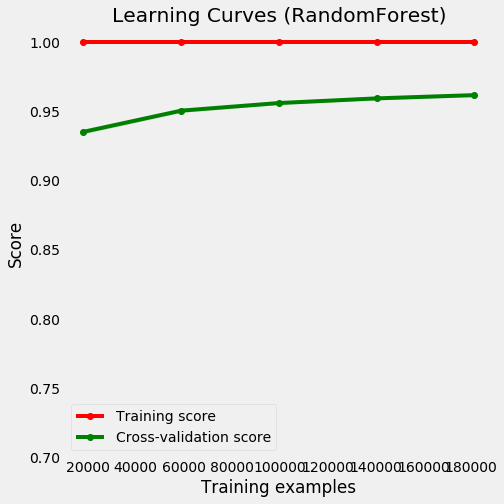

In [44]:
title = "Learning Curves (RandomForest)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=50, test_size=0.2, random_state=0)  # changed 100 to 50
estimator = RandomForestClassifier(**mdl_params)
ylim = (0.7, 1.01)
n_jobs = 7
train_sizes = np.linspace(.1, 1.0, 5)
fig = plt.figure(figsize=(7, 7))
plt.title(title)
if ylim is not None:
    plt.ylim(*ylim)
plt.xlabel("Training examples")
plt.ylabel("Score")
train_sizes, train_scores, test_scores = learning_curve(
    estimator, all_X, all_y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
plt.grid()
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
         label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
         label="Cross-validation score")
plt.legend(loc="best")
plt.tight_layout(pad=0.5, w_pad=20, h_pad=0.5)
plt.show()
# plt.savefig('loanwords.prob.solutions.learningcurve.png')


# Appendix

### Find which texts in the Latin Library have the most transliterated Greek

In [46]:
corpus_files = {}
latin_reader = get_corpus_reader(corpus_name='latin_text_latin_library', language='latin')
greek_in_corpus_selection = set()
found_greek = []

for full_path in tqdm(latin_reader.fileids(), total=len(latin_reader.fileids()), unit='files'):
    filename = full_path[full_path.rfind('/') + 1:]
    unseen_X = process_latin_text_pipeline.fit_transform(list(latin_reader.sents([full_path])))
    distinct_unseen = distinct_words(unseen_X)
    unseen_words = list(distinct_unseen)
    total_words = [word
                   for sentence in unseen_X
                   for word in sentence]
    arr = classifier.predict(sparse.csr_matrix(np.array([encode_word(word, char_idx, max_len) for word in total_words])))
    total_greek_words = np.count_nonzero(arr)
    marks = arr.tolist()
    if marks:
        found_greek = [total_words[idx]
                       for idx, point in enumerate(marks)
                       if point == 1]
        greek_in_corpus_selection |= set(found_greek)
        corpus_files[filename] = (len(total_words), total_greek_words)


100%|██████████| 2141/2141 [1:15:06<00:00,  2.69s/files]


In [47]:
print(f'Total Greek words found in Latin selection {len(greek_in_corpus_selection):,}')
print(f'Number of Greek words not in training data: {len(greek_in_corpus_selection - only_greek_transliterated):,}')
print(f'Random sample: {random.sample(greek_in_corpus_selection, 20)}')

Total Greek words found in Latin selection 16,612
Number of Greek words not in training data: 14,304
Random sample: ['gelôtopoio', 'Andr', 'constantinopolitana', 'solummagna', 'anhelas', 'Lezenais', 'Colophone', 'prias', 'Strete', 'metrocomias', 'stephephoros', 'peritretos', 'intelligentiores', 'seriò', 'etumos', 'Athamantidos', 'apodixin', 'pie', 'purous', 'mag']


In [48]:
print(len(corpus_files ))
rankings = [(key, val[0], val[1], val[1]/val[0]) for key, val in corpus_files.items()]
rankings.sort(key=lambda x: x[3])
for rank in rankings:
    print (rank)

2039
('preface.txt', 411, 0, 0.0)
('serm18.txt', 1363, 0, 0.0)
('balde1.txt', 109, 0, 0.0)
('gall5.txt', 7489, 0, 0.0)
('legagr3.txt', 1249, 0, 0.0)
('repub4.txt', 202, 0, 0.0)
('dicquid.txt', 52, 0, 0.0)
('dulcesolum.txt', 73, 0, 0.0)
('dumdomus.txt', 46, 0, 0.0)
('dumestas.txt', 13, 0, 0.0)
('eutropius1.txt', 1569, 0, 0.0)
('eutropius9.txt', 2083, 0, 0.0)
('fortunat.txt', 101, 0, 0.0)
('contro.txt', 926, 0, 0.0)
('qualitate.txt', 353, 0, 0.0)
('gaud.txt', 113, 0, 0.0)
('janus2.txt', 2, 0, 0.0)
('jfkhonor.txt', 6, 0, 0.0)
('liv.per.txt', 2, 0, 0.0)
('liv.per1.txt', 444, 0, 0.0)
('liv.per10.txt', 117, 0, 0.0)
('liv.per101.txt', 77, 0, 0.0)
('liv.per102.txt', 97, 0, 0.0)
('liv.per106.txt', 111, 0, 0.0)
('liv.per108.txt', 81, 0, 0.0)
('liv.per11.txt', 198, 0, 0.0)
('liv.per110.txt', 121, 0, 0.0)
('liv.per111.txt', 106, 0, 0.0)
('liv.per112.txt', 129, 0, 0.0)
('liv.per114.txt', 92, 0, 0.0)
('liv.per115.txt', 77, 0, 0.0)
('liv.per117.txt', 125, 0, 0.0)
('liv.per118.txt', 72, 0, 0.0)
('liv.

('q1.13.txt', 8686, 200, 0.023025558369790467)
('q1.28.txt', 2763, 64, 0.02316322837495476)
('digest14.txt', 10011, 232, 0.02317450804115473)
('theod11.txt', 25347, 589, 0.02323746399968438)
('theod16.txt', 19590, 457, 0.023328228688106176)
('letabundus.txt', 128, 3, 0.0234375)
('codex2.txt', 24579, 582, 0.023678750152569268)
('spinoza.ethica2.txt', 12650, 300, 0.023715415019762844)
('albertanus.sermo.txt', 2509, 60, 0.023913909924272617)
('albertanus3.txt', 9946, 240, 0.024130303639654134)
('walter8.txt', 455, 11, 0.024175824175824177)
('apicius3.txt', 1074, 26, 0.024208566108007448)
('liv.per81.txt', 41, 1, 0.024390243902439025)
('digest11.txt', 9633, 235, 0.024395307796117514)
('codex8.txt', 31513, 774, 0.024561292165138197)
('q1.26.txt', 1099, 27, 0.02456778889899909)
('apuleius.mundo.txt', 6643, 165, 0.02483817552310703)
('suet.tibullus.txt', 80, 2, 0.025)
('1644.txt', 3235, 81, 0.025038639876352395)
('theod15.txt', 8260, 210, 0.025423728813559324)
('theod06.txt', 17630, 454, 0.02

# That's all for now folks!